In [1]:
import torch
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from collections import Counter
import matplotlib.pyplot as plt

from glob import glob

from main import *
from utils.util import *
from utils.model import *
from utils.train import *
from utils.dataset import *

pd.set_option('display.max_columns', 200)

In [ ]:
# seeds = [100, 2000, 400, 3313, 1111]
# N_max_gamma = [(40, 20), (100, 50), (200, 100), 
#                (2000, 100), (2000, 10), (1000, 30), (1000, 10)]


# for seed in tqdm(seeds):
#     for N_max, gamma in tqdm(N_max_gamma):
#         print(f'>> seed: {seed}, N_max: {N_max}, gamma: {gamma}')   
#         ret = main(N_max=N_max, gamma=gamma, seed=seed, NUM_CLASSES=10, every_epoch=300)
#         # torch.save(ret, f'../results/ret_{seed}_{N_max}_{gamma}.pt')
#         break
#     break

In [4]:
def parsing_result(ret):
    params = pd.DataFrame.from_dict(ret['params'], orient='index').T
    
    score = pd.DataFrame.from_dict(ret['result'], orient='index').reset_index().melt(id_vars='index').dropna()#[['obs_acc', 'mis_acc', 'test_acc', 'converge','mis_class_acc', 'test_class_acc']].reset_index().melt(id_vars='index').dropna()
    score['col_name'] = score['index'] + '_' + score['variable']
    score = score[['col_name', 'value']].set_index('col_name').T.reset_index(drop=True)
    cnt = ret['class_dist'].sort_index().to_frame().T.reset_index(drop=True)
    return pd.concat([cnt, params, score], axis=1)

class Reporter:
    def __init__(self, f_path_lst):
        print(len(f_path_lst))
        self.result = self.make_result(f_path_lst)
        self.result['ratio'] = (self.result[0] / self.result[1]).apply(lambda x: 1/x if x < 1 else x) 
        self.result = self.result.applymap(lambda x: float(x) if type(x) == str else x)
        self.result['label_weight'] = self.result['label_weight'].astype(str)
        label2ratio_mean = self.result.groupby('label_weight')['ratio'].mean()
        self.result['imbalance_ratio_mean'] = self.result['label_weight'].apply(lambda x: label2ratio_mean[x]).round(3).astype(str)
        self.result['response_response_model_res_prob'] = self.result['response_response_model_res_prob'].apply(lambda x: np.array(x))
        
        for dataset in ['obs', 'mis', 'test']:
            for metric in ['acc', 'f1']:
                self.result[f'diff_{dataset}_{metric}'] = self.result[f'response_{dataset}_{metric}'] - self.result[f'outcome_{dataset}_{metric}']
        for dataset in ['mis', 'test']:
            for metric in ['acc', 'f1']:
                self.result[f'diff_{dataset}_adjust_{metric}'] = self.result[f'response_{dataset}_adjust_{metric}'] - self.result[f'outcome_{dataset}_{metric}']
        
        # self.result['N_max_gamma'] = self.result['N_max'].astype(str) + '_' + self.result['gamma'].astype(str)
        self.class_acc = self.make_class_acc()
        # self.result['use_pool'] = self.result['use_pool'].fillna(True)
    def __call__(self):
        return self.result.drop(columns = ['response_mis_class_acc', 'outcome_mis_class_acc', 'outcome_test_class_acc', 
                                           'response_test_class_acc'])
        
    def make_result(self, f_path_lst):
        concat = []
        for path in f_path_lst:
            ret = torch.load(path)
            del ret['model']
            result_df = parsing_result(ret)
            concat.append(result_df)
        return pd.concat(concat, axis=0, ignore_index=True)
    
    def make_class_acc(self):
        class_acc = pd.DataFrame()
        for model in ['outcome', 'response']:
            for data in ['mis', 'test']:
                col = f'{model}_{data}_class_acc'
                class_acc[[f'{col}_{i}' for i in range(2)]] = pd.concat(self.result[col].values, axis=1).T
        return class_acc

    def make_class_f1(self):
        class_acc = pd.DataFrame()
        for model in ['outcome', 'response']:
            for data in ['mis', 'test']:
                col = f'{model}_{data}_class_f1'
                class_acc[[f'{col}_{i}' for i in range(2)]] = pd.concat(self.result[col].values, axis=1).T
        return class_acc


    def plot_class_acc(self, idx):
        class_acc_idx = self.class_acc.iloc[idx:idx+1].melt()\
                        .assign(dataset = lambda x: x['variable'].apply(lambda y: y.split('_')[1]))\
                            .assign(model = lambda x: x['variable'].apply(lambda y: y.split('_')[0]))\
                            .assign(label = lambda x: x['variable'].apply(lambda y: y.split('_')[-1]))


        g = sns.FacetGrid(class_acc_idx, col='dataset', aspect=1.5, height=3)
        for i in range(len(g.axes[0])):
            g.axes[0][i].grid(axis='y', alpha=0.2)
        g.map(sns.barplot, 'label', 'value', 'model',
            hue_order=['outcome', 'response'],
            palette=sns.color_palette(['navy','coral'])
            )
        g.add_legend()

        outcome_mis_acc = round(self.result.iloc[idx]['outcome_mis_acc'], 4)
        response_mis_acc = round(self.result.iloc[idx]['response_mis_acc'], 4)
        outcome_test_acc = round(self.result.iloc[idx]['outcome_test_acc'], 4)
        response_test_acc = round(self.result.iloc[idx]['response_test_acc'], 4)

        g.axes[0][0].set_title(f"dataset = mis\n(outcome_acc : {outcome_mis_acc}, response_acc : {response_mis_acc})")
        g.axes[0][1].set_title(f"dataset = test\n(outcome_acc : {outcome_test_acc}, response_acc : {response_test_acc})")

        g.fig.suptitle(f"({idx})Accuracy Difference by model(converge:{self.result.iloc[idx]['response_converge']})", weight='semibold', size=20, y=1.2)
        g.axes[0][0].set_ylabel('Accuracy')
        plt.show()


    def plot_data_acc(self):
        g = sns.FacetGrid(self.result, col='NUM_CLASSES', 
                        #   row='use_pool', 
                          aspect=1.5, height=3)

        g.map(sns.stripplot, 'diff_mis_acc', 'label_weight', 'response_converge',
            # hue_order=['True', 'False'],
            palette=sns.color_palette(['tomato', 'royalblue'])
            )
        for i in range(len(g.axes[0])):
            for j in range(len(g.axes[0])):
                g.axes[i][j].grid(axis='both', alpha=0.2)  
        g.add_legend(title='converge')
        g.fig.suptitle(f"Accuracy Difference by Data Disribution", weight='semibold', size=20, y=1.1)

        plt.show()

In [13]:
reporter_resnet = Reporter(glob('../results_resnet/*'))

20


In [14]:
reporter_alex = Reporter(glob('../results_alex/*'))


20


/home/hongrok/anaconda3/envs/ate/lib/python3.10/site-packages/seaborn/axisgrid.py:712: UserWarning: Using the stripplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/home/hongrok/anaconda3/envs/ate/lib/python3.10/site-packages/seaborn/axisgrid.py:717: UserWarning: Using the stripplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/home/hongrok/anaconda3/envs/ate/lib/python3.10/site-packages/seaborn/axisgrid.py:848: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  func(*plot_args, **plot_kwargs)
/home/hongrok/anaconda3/envs/ate/lib/python3.10/site-packages/seaborn/axisgrid.py:848: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  func(*plot_args, **plot_kwargs)


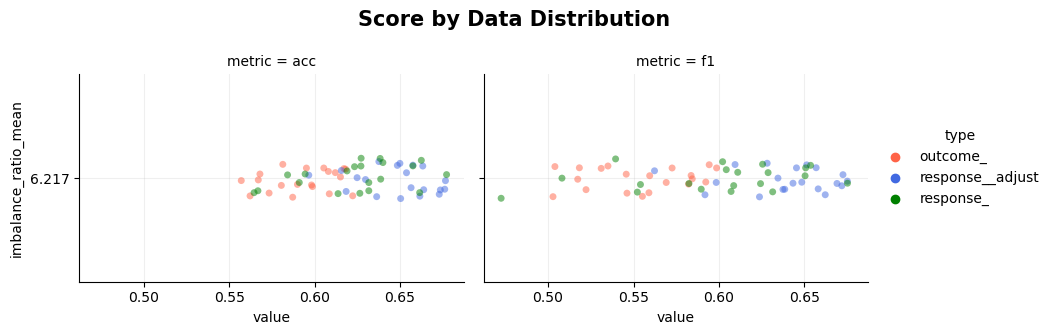

In [9]:
col_main = [0, 1, 'alpha', 'tau', 'model_seed','label_weight', 'ratio', 'imbalance_ratio_mean']
col_acc = ['outcome_mis_acc', 'response_mis_adjust_acc', 'response_mis_acc', 
          #  'option4_mis_acc'
           ]
col_f1 = ['outcome_mis_f1', 'response_mis_adjust_f1', 'response_mis_f1', 
          # 'option4_mis_f1'
          ]
col_prob = ['response_mis_res_prob', 'response_response_model_res_prob']
col_coef = ['label_weight', 'response_coef']
melt = reporter.result[col_main+col_acc+col_f1].sort_values('imbalance_ratio_mean').melt(id_vars=col_main)
melt['metric'] = melt['variable'].apply(lambda x: x.split('_')[-1])
melt['model'] = melt.variable.apply(lambda x: '_'.join(x.replace('mis', '').split('_')[:-1]))
melt

g = sns.FacetGrid(melt, col='metric', aspect=1.5, height=3)
g.map(sns.stripplot, 'value', 'imbalance_ratio_mean', 'model',
      alpha=0.5,
        # hue_order=['True', 'False'],
        palette=sns.color_palette(['tomato', 'royalblue', 'green', 'purple'],)
        ) 
   
for i in range(len(g.axes)):
    for j in range(len(g.axes[i])):
        g.axes[i][j].grid(axis='both', alpha=0.2)
g.add_legend(title='type')
g.fig.suptitle(f"Score by Data Distribution", weight='semibold', size=15, y=1.1)

plt.show()

/home/hongrok/anaconda3/envs/ate/lib/python3.10/site-packages/seaborn/axisgrid.py:712: UserWarning: Using the stripplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/home/hongrok/anaconda3/envs/ate/lib/python3.10/site-packages/seaborn/axisgrid.py:717: UserWarning: Using the stripplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/home/hongrok/anaconda3/envs/ate/lib/python3.10/site-packages/seaborn/axisgrid.py:848: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  func(*plot_args, **plot_kwargs)
/home/hongrok/anaconda3/envs/ate/lib/python3.10/site-packages/seaborn/axisgrid.py:848: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  func(*plot_args, **plot_kwargs)


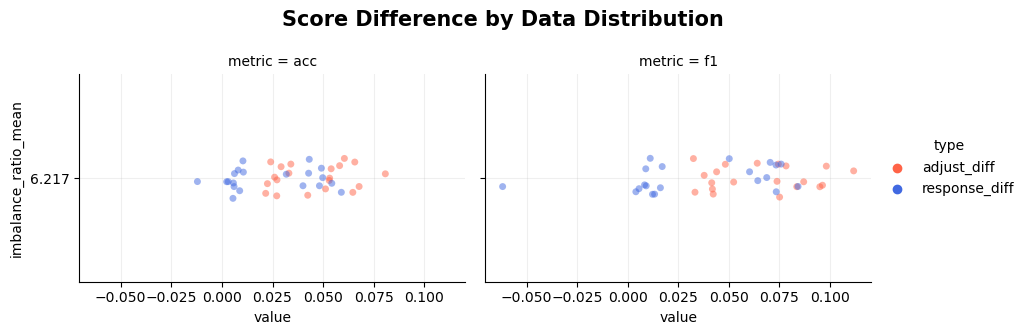

In [19]:
temp = reporter.result[col_main+col_acc+col_f1].sort_values('imbalance_ratio_mean')

for metric in ['acc', 'f1']:
    base = temp[f'outcome_mis_{metric}']
    
    temp[f'adjust_diff_{metric}'] = temp[f'response_mis_adjust_{metric}'] - base
    temp[f'response_diff_{metric}'] = temp[f'response_mis_{metric}'] - base
    # temp[f'option4_diff_{metric}'] = temp[f'option4_mis_{metric}'] - base
    
    temp.drop([f'outcome_mis_{metric}', f'response_mis_adjust_{metric}', f'response_mis_{metric}',
            #    f'option4_mis_{metric}'
               ], axis=1, inplace=True)
    
melt = temp.melt(id_vars=col_main)
melt['metric'] = melt['variable'].apply(lambda x: x.split('_')[-1])
melt['model'] = melt.variable.apply(lambda x: '_'.join(x.replace('mis', '').split('_')[:-1]))
melt

g = sns.FacetGrid(melt, col='metric', aspect=1.5, height=3)
g.map(sns.stripplot, 'value', 'imbalance_ratio_mean', 'model',
      alpha=0.5,
        # hue_order=['True', 'False'],
        palette=sns.color_palette(['tomato', 'royalblue', 'green', 'purple'],)
        ) 
   
for i in range(len(g.axes)):
    for j in range(len(g.axes[i])):
        g.axes[i][j].grid(axis='both', alpha=0.2)
g.add_legend(title='type')
g.fig.suptitle(f"Score Difference by Data Distribution", weight='semibold', size=15, y=1.1)

plt.show()

In [12]:
def make_table(reporter):
   col_obs_acc = ['outcome_obs_acc', 'response_obs_acc', 
               #    'option4_obs_acc'
                  ]

   for_table = reporter.result[['response_converge']+col_main+col_obs_acc+col_acc+col_f1+col_prob+col_coef].sort_values('imbalance_ratio_mean').round(4)
   #.drop(columns=['label_weight'])
   for_table = for_table.applymap(lambda x: [round(float(val), 4) for val in x] if (type(x) != int) and (type(x) != float) and (type(x) != str) and (type(x) != bool) else x)
   return for_table
# 5000-for_table[[0, 1]]

In [15]:
table_res = make_table(reporter_resnet)
table_alex = make_table(reporter_alex)

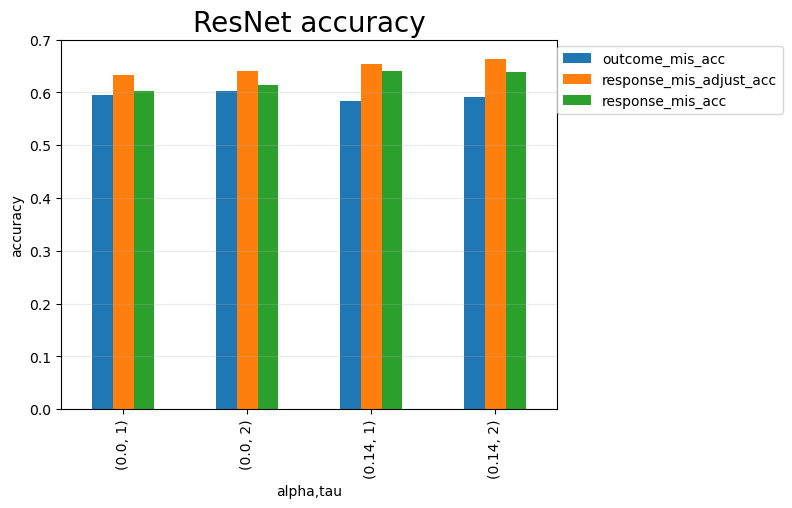

In [48]:
table_res.groupby(['alpha', 'tau'])[['outcome_mis_acc', 'response_mis_adjust_acc', 'response_mis_acc']].agg(('mean', 'std')).round(4)
table_res.groupby(['alpha', 'tau'])[['outcome_mis_acc', 'response_mis_adjust_acc', 'response_mis_acc']].mean().round(4).plot.bar()

plt.grid(alpha=0.25, axis='y')
plt.legend(loc=(1, 0.8))
plt.title('ResNet accuracy', size=20)
plt.ylabel('accuracy')
plt.ylim(0, 0.7)
plt.show()


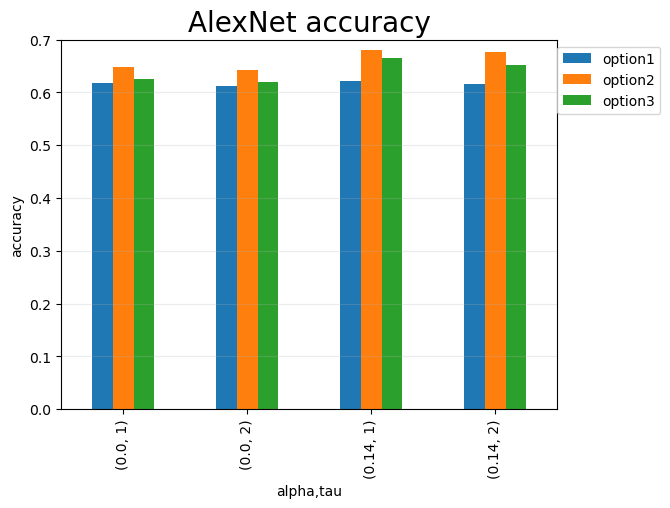

In [53]:
table_alex.groupby(['alpha', 'tau'])[['outcome_mis_acc', 'response_mis_adjust_acc', 'response_mis_acc']].agg(('mean', 'std')).round(4)
table_alex.groupby(['alpha', 'tau'])[['outcome_mis_acc', 'response_mis_adjust_acc', 'response_mis_acc']].mean().round(4).plot.bar()
plt.grid(alpha=0.25, axis='y')
plt.legend(labels=['option1', 'option2', 'option3'], loc=(1, 0.8))
plt.title('AlexNet accuracy', size=20)
plt.ylabel('accuracy')
plt.ylim(0, 0.7)
plt.show()

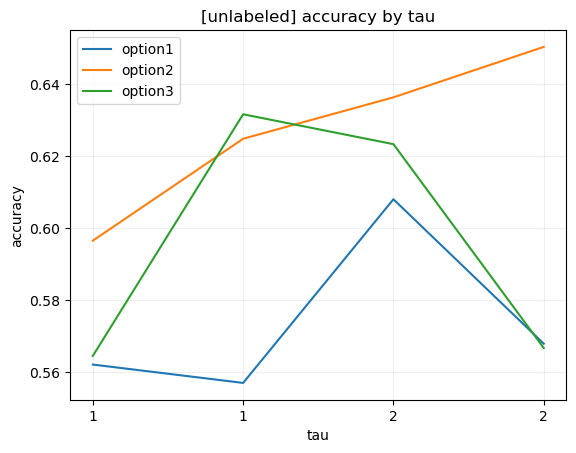

In [28]:
temp = for_table.sort_values('tau').query('tau >= 1 and model_seed == 200').reset_index(drop=True)
temp[['outcome_mis_acc','response_mis_adjust_acc','response_mis_acc']].plot()
plt.legend(['option1', 'option2', 'option3'])
plt.xticks(range(len(temp)), temp['tau'])
plt.xlabel('tau')
plt.ylabel('accuracy')
plt.grid(alpha=0.2)
plt.title('[unlabeled] accuracy by tau')
plt.show()

In [15]:
reporter.result['response_response_model_res_prob'].apply(lambda x: np.array(x)).mean()

array([0.98422057, 0.00784867])

In [16]:
reporter.result['response_coef'].mean()

array([ 4.13314305, -4.83953163])

In [30]:
col_main = [0, 1, 'model_seed','label_weight', 'ratio', 'imbalance_ratio_mean']
col_acc = ['outcome_mis_acc', 'response_mis_adjust_acc', 'response_mis_acc', 'option4_mis_acc']
col_f1 = ['outcome_mis_f1', 'response_mis_adjust_f1', 'response_mis_f1', 'option4_mis_f1']
col_prob = ['response_mis_res_prob', 'response_response_model_res_prob']
col_coef = ['response_coef']
display(reporter.result[col_main+col_prob].groupby('imbalance_ratio_mean')[['response_mis_res_prob', 'response_response_model_res_prob']].mean().applymap(lambda x: x.round(2)).T)
display(reporter.result[col_main+col_coef].groupby(['imbalance_ratio_mean', 'label_weight'])[['response_coef']].mean().applymap(lambda x: x.round(2)).T)

imbalance_ratio_mean,1.827,3.921,6.794,7.315
response_mis_res_prob,"[0.08, 0.05]","[0.14, 0.04]","[0.02, 0.12]","[0.12, 0.02]"
response_response_model_res_prob,"[0.05, 0.04]","[0.07, 0.05]","[0.04, 0.05]","[0.06, 0.03]"


imbalance_ratio_mean,1.827,3.921,6.794,7.315
label_weight,"[-2.4, -3]","[-1.8, -3.2]","[-4, -2]","[-2, -4]"
response_coef,"[-2.94, -3.12]","[-2.52, -3.04]","[-3.13, -2.94]","[-2.82, -3.49]"


In [29]:
display(reporter.result[col_main+col_acc].groupby('imbalance_ratio_mean')[col_acc].mean().T)
display(reporter.result[col_main+col_f1].groupby('imbalance_ratio_mean')[col_f1].mean().T)

imbalance_ratio_mean,1.827,3.921,6.794,7.315
outcome_mis_acc,0.698996,0.649255,0.569069,0.602241
response_mis_adjust_acc,0.704874,0.671583,0.599207,0.638214
response_mis_acc,0.700214,0.656955,0.572979,0.614119
option4_mis_acc,0.706134,0.658513,0.567185,0.608594


imbalance_ratio_mean,1.827,3.921,6.794,7.315
outcome_mis_f1,0.694379,0.634157,0.515114,0.569617
response_mis_adjust_f1,0.701946,0.665027,0.568699,0.624235
response_mis_f1,0.695611,0.645378,0.521091,0.588145
option4_mis_f1,0.700642,0.643992,0.509458,0.577518


In [ ]:
# label_weight과 response coef 비교
# 실제 p(response)와 예측한 p(response)의 평균 비교
# adjust값과 odds결과 비교

pd.set_option('display.max_columns', 100)
reporter()